In [11]:
import numpy as np
import pandas as pd
import os
import re
import tensorflow as tf
from threading import Thread
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201, Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

init_notebook_mode(connected=True)

# Product Recommendations: Visually Similar Content Filtering using KNNs
- A recommender system, or a recommendation system, is a subclass of information filtering system that provide suggestions for items that are most pertinent to a particular user.Typically, the suggestions refer to various decision-making processes, such as what product to purchase, what music to listen to, or what online news to read. Recommender systems are particularly useful when an individual needs to choose an item from a potentially overwhelming number of items that a service may offer.
- Recommender Systems can be broadly classified into 3 types
    - Collaborative Filtering
    - Content-Based Filtering
    - Hybrid
- This notebook will demonstrate the Content-Based filtering, which are based on the description of an item and a profile of the user’s preferred choices. In a content-based recommendation system, features are used to describe the items, besides, a user profile is built to state the type of item this user likes. In other words, the algorithms try to recommend products that are similar to the ones that a user has liked in the past.
- Although we do not have any kind of user profile data, we will use K-Nearest Neighbours algorithms to recommend products which have visually similar features, such as the ones you see in shopping websites **e.g. "Products that are similar to this"**

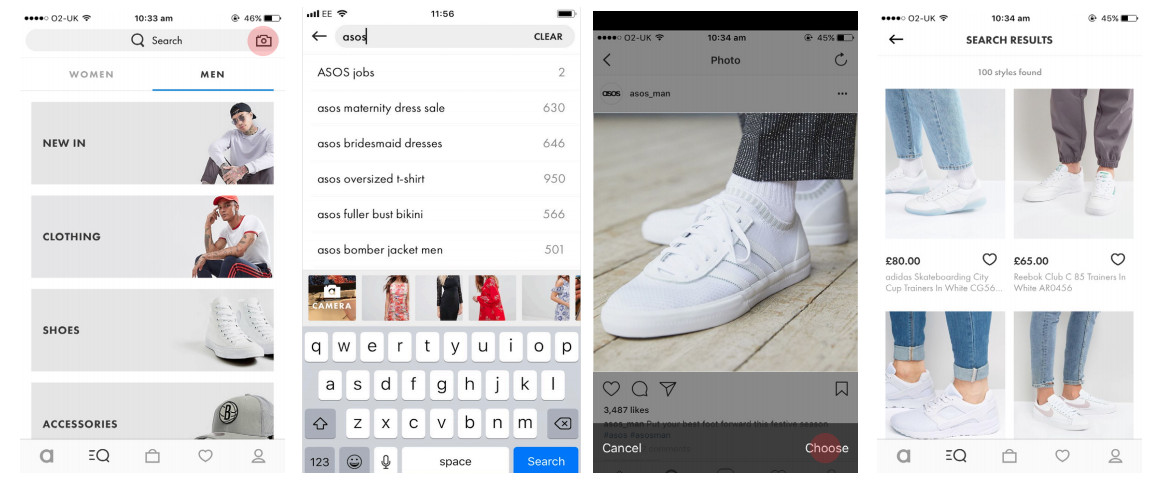

# EDA and Visualization
- Lets first merge the image data and product meta data to get the required dataset
- We will look at some of the categories and subcategories to understand which categories are more dominant

## Images Dataframe

In [12]:
images_df = pd.read_csv("./data/fashion-dataset/images.csv")

## Product Meta Data Dataframe

In [13]:
styles_df = pd.read_csv("./data/fashion-dataset/styles.csv", on_bad_lines='skip')

## Create Unique ID in both Dataframes

In [14]:
images_df['id'] = images_df['filename'].apply(lambda x: x.replace(".jpg","")).astype(int)

In [15]:
images_df

,filename,link,id
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...,15970
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...,39386
2,59263.jpg,http://assets.myntassets.com/v1/images/style/p...,59263
3,21379.jpg,http://assets.myntassets.com/v1/images/style/p...,21379
4,53759.jpg,http://assets.myntassets.com/v1/images/style/p...,53759
...,...,...,...
44441,17036.jpg,http://assets.myntassets.com/v1/images/style/p...,17036
44442,6461.jpg,http://assets.myntassets.com/v1/images/style/p...,6461
44443,18842.jpg,http://assets.myntassets.com/v1/images/style/p...,18842
44444,46694.jpg,http://assets.myntassets.com/v1/images/style/p...,46694


## Merging the Two Dataframes

In [16]:
data = styles_df.merge(images_df,on='id',how='left').reset_index(drop=True)
data['filename'] = data['filename'].apply(lambda x: os.path.join("./data/fashion-dataset/images/",x))

In [17]:
image_files = os.listdir("./data/fashion-dataset/images")

## Removing Products for which images are not present

In [18]:
data['file_found'] = data['id'].apply(lambda x: f"{x}.jpg" in image_files)

In [19]:
data = data[data['file_found']].reset_index(drop=True)

## Final Data

In [20]:
data.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link,file_found
0,10007,Women,Apparel,Topwear,Tshirts,White,Fall,2011.0,Sports,Nike Women As Trophy Swo White T-Shirts,./data/fashion-dataset/images/10007.jpg,http://assets.myntassets.com/v1/images/style/p...,True
1,10000,Women,Apparel,Bottomwear,Skirts,White,Summer,2011.0,Casual,Palm Tree Girls Sp Jace Sko White Skirts,./data/fashion-dataset/images/10000.jpg,http://assets.myntassets.com/v1/images/style/p...,True
2,10009,Men,Apparel,Topwear,Tshirts,Red,Fall,2011.0,Sports,Nike Men Town Round Red Neck T-Shirts,./data/fashion-dataset/images/10009.jpg,http://assets.myntassets.com/v1/images/style/p...,True
3,10008,Men,Apparel,Topwear,Tshirts,Navy Blue,Fall,2011.0,Sports,Nike Men Town Navy Blue T-Shirts,./data/fashion-dataset/images/10008.jpg,http://assets.myntassets.com/v1/images/style/p...,True
4,10001,Women,Apparel,Bottomwear,Skirts,Blue,Summer,2011.0,Casual,Palm Tree Kids Girls Sp Jema Skt Blue Skirts,./data/fashion-dataset/images/10001.jpg,http://assets.myntassets.com/v1/images/style/p...,True


## Checking for Null Values

In [21]:
data.isnull().sum()

id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
filename              0
link                  0
file_found            0
dtype: int64

## Visualizations
- Main Categories Count
- Sub Categories Count
- Products by Season Count
- Product Usage type Count

In [22]:
fig = px.bar(data.groupby('masterCategory').count().reset_index(), x='masterCategory',y='id',title='Count per Product Category')
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})

In [23]:
fig = px.bar(data.groupby('subCategory').count().reset_index(), x='subCategory',y='id',title='Count per Product Sub-category', color='subCategory')
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})

In [24]:
fig = px.bar(data.groupby('season').count().reset_index(), x='season', y='id', title='Count per Season Category')
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})

In [25]:
fig = px.bar(data.groupby('usage').count().reset_index(), x='usage', y='id', title='Count per Usage Category')
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})

## Remove Unneccessary Columns
- As for now we will delete the product display name, but in the future versions of the notebook we will also use the text features

In [26]:
data.drop(columns=['productDisplayName','link','file_found'],inplace=True)
data

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,filename
0,10007,Women,Apparel,Topwear,Tshirts,White,Fall,2011.0,Sports,./data/fashion-dataset/images/10007.jpg
1,10000,Women,Apparel,Bottomwear,Skirts,White,Summer,2011.0,Casual,./data/fashion-dataset/images/10000.jpg
2,10009,Men,Apparel,Topwear,Tshirts,Red,Fall,2011.0,Sports,./data/fashion-dataset/images/10009.jpg
3,10008,Men,Apparel,Topwear,Tshirts,Navy Blue,Fall,2011.0,Sports,./data/fashion-dataset/images/10008.jpg
4,10001,Women,Apparel,Bottomwear,Skirts,Blue,Summer,2011.0,Casual,./data/fashion-dataset/images/10001.jpg
5,10006,Men,Apparel,Topwear,Tshirts,Black,Fall,2011.0,Sports,./data/fashion-dataset/images/10006.jpg
6,10015,Men,Apparel,Topwear,Tshirts,White,Fall,2011.0,Casual,./data/fashion-dataset/images/10015.jpg
7,10012,Men,Apparel,Bottomwear,Track Pants,Navy Blue,Fall,2011.0,Sports,./data/fashion-dataset/images/10012.jpg
8,10013,Men,Apparel,Topwear,Tshirts,Yellow,Fall,2011.0,Sports,./data/fashion-dataset/images/10013.jpg
9,10014,Unisex,Accessories,Headwear,Caps,Blue,Fall,2011.0,Sports,./data/fashion-dataset/images/10014.jpg


# Train-Val Split
- Although we won't be performing a traditional training validation approach, we still want to perform some of the steps on the training set and use those learned weights on the validation set
- Shuffle the data randomly 
- 80% data for train
- 20% data for validation

In [27]:
data = data.sample(frac=1).reset_index(drop=True)
n = len(data)
train = data.iloc[:int(n*0.8),:]
val = data.iloc[int(n*0.8):,:].reset_index(drop=True)

## Data Generator

In [28]:
datagen = ImageDataGenerator(rescale=1/255.)

train_generator = datagen.flow_from_dataframe(dataframe=train,
                                             target_size=(256,256),
                                             x_col='filename',
                                             class_mode=None,
                                             batch_size=32,
                                             shuffle=False,
                                             classes=['images'])

val_generator = datagen.flow_from_dataframe(dataframe=val,
                                             target_size=(256,256),
                                             x_col='filename',
                                             class_mode=None,
                                             batch_size=32,
                                             shuffle=False,
                                             classes=['images'])

Found 16 validated image filenames.
Found 5 validated image filenames.


/opt/anaconda3/lib/python3.9/site-packages/keras/preprocessing/image.py:1071: UserWarning:

`classes` will be ignored given the class_mode="None"



# Feature Extraction: Pre-trained VGG16 
- We will extract the features of the image using the pre-trained deep neural VGG16 network
- We will extract the final features of the network by using global average pooling on the final convolutional block of the network

In [29]:
base_model = VGG16(include_top=False,input_shape=(256,256,3))

model = Sequential()
for layer in base_model.layers:
    model.add(layer)
model.add(GlobalAveragePooling2D())
model.summary()

2022-11-17 14:01:59.683172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                         

## Extracting Features of Training and Validation Set

In [30]:
train_features = model.predict(train_generator,verbose=1)
val_features = model.predict(val_generator,verbose=1)

1/1 [==============================] - 2s 2s/step


# Dimensionality Reduction
- The features extracted using the VGG16 Network product a vector of 512 features. So if we have lets say 10000 products the matrix of our data will be of the dimension 10000 x 512
- Lets see if we can reduce the dimension of this matrix
- For a linear projection based dimensionality reduction method to work there should be high correlation amongst the features
- But to visualize a correlation coeff table of such a high dimensional matrix will be highly resource utilizing
- Lets perform the PCA and see the variance explaination of the principal components to check if our linear projection approach works

In [31]:
from sklearn.decomposition import PCA

## Illustration of how PCA finds the axes where the within data variability will be maximum
- Lets proceed with 2 principal components first so that we can visualize them in 2D
- We will then look at the Cumulative Variance Explanation to find the right amount of principal components

<img src="https://miro.medium.com/max/1400/1*37a_i1t1tDxDYT3ZI6Yn8w.gif">

In [32]:
pca = PCA(2)
pca.fit(train_features)
train_pca = pca.transform(train_features)

In [33]:
test_pca = pca.fit_transform(val_features)

In [34]:
train_pca = pd.DataFrame(train_pca)
train = train.iloc[:,0:10]
train = train.merge(train_pca, how='left', left_index=True, right_index=True)

# Visualization: Principal Components

In [35]:
fig = px.scatter(train, x=0, y=1, color="masterCategory", title='Main Category', height=600, labels={
                     "0": "Principal Component 1",
                     "1": "Principal Component 2"})
fig.show()

In [36]:
fig = px.scatter(train, x=0, y=1, color="gender", title='Gender', height=600, labels={
                     "0": "Principal Component 1",
                     "1": "Principal Component 2"})
fig.show()

In [37]:
fig = px.scatter(train, x=0, y=1, color="subCategory", title='Sub Category', height=600, labels={
                     "0": "Principal Component 1",
                     "1": "Principal Component 2"})
fig.show()

In [38]:
fig = px.scatter(train[train['season'].notna()], x=0, y=1, color="season", title='Season', height=600, labels={
                     "0": "Principal Component 1",
                     "1": "Principal Component 2"})
fig.show()

In [39]:
fig = px.scatter(train[train['usage'].notna()], x=0, y=1, color="usage", title='Usage', height=600, labels={
                     "0": "Principal Component 1",
                     "1": "Principal Component 2"})
fig.show()

**Inference:**
- The 2 principal components show a reasonably good separability in terms of main product categories
- Maybe after taking more principal components the seprability will be more evident

In [40]:
pca = PCA()
pca.fit(train_features)
train_pca = pca.transform(train_features)
variance_explained = np.cumsum(pca.explained_variance_ratio_)
pcs = range(1,len(variance_explained)+1)

# Reduced Dimensions: 512 -> 313
- First 313 Principal Components explain 99% of the variance in data
- We will reduce the image feature dimensions to 313

In [41]:
px.line(x = pcs, y = variance_explained, title = 'Principal Components Cumulative Explained Variance', height=600,  labels={
                     "x": "Principal Components",
                     "y": "Explained Variance"})

In [42]:
val_pca = pca.fit_transform(val_features)[:,:313]
val_pca = pd.DataFrame(val_pca)
val = val.iloc[:,0:10]
val = val.merge(val_pca, how='left', left_index=True, right_index=True)

In [43]:
X = val.iloc[:,-313:]
y = val['id']